In [1]:

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
from matplotlib import pyplot as plt
from ArucoDetector import *
from pprint import pprint

In [2]:
imsize = (1920, 1080)
# K = cv2.getDefaultNewCameraMatrix(
    # np.diag([1920, 1920, 1]), imsize, True)
K = np.array([[1867, 0, 960], [0, 1575, 540], [0, 0, 1]])
print(K)
arDetector = ArUcoDetector(imsize, K)

[[1867    0  960]
 [   0 1575  540]
 [   0    0    1]]


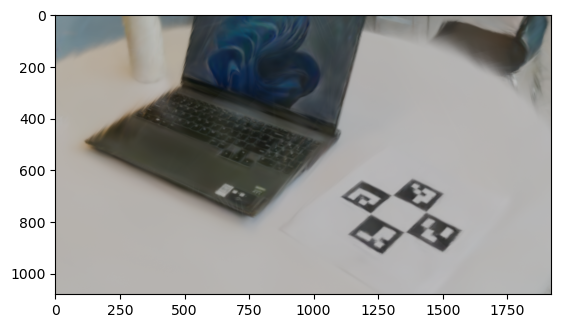

In [3]:
frame = cv2.imread("images/detected_marker_3.png")
# frame = cv2.imread("images/DICT_4X4_250_id_0123.png")
fig = plt.figure()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [4]:
# detect the marker
corners, ids, rejected = arDetector.detector.detectMarkers(frame)
print(ids.ravel())
pprint(corners)

[2 3 1 0]
(array([[[1223.,  775.],
        [1351.,  842.],
        [1268.,  923.],
        [1134.,  852.]]], dtype=float32),
 array([[[1436.,  769.],
        [1575.,  834.],
        [1502.,  915.],
        [1359.,  841.]]], dtype=float32),
 array([[[1187.,  645.],
        [1302.,  700.],
        [1224.,  766.],
        [1104.,  706.]]], dtype=float32),
 array([[[1382.,  637.],
        [1504.,  693.],
        [1438.,  760.],
        [1310.,  698.]]], dtype=float32))


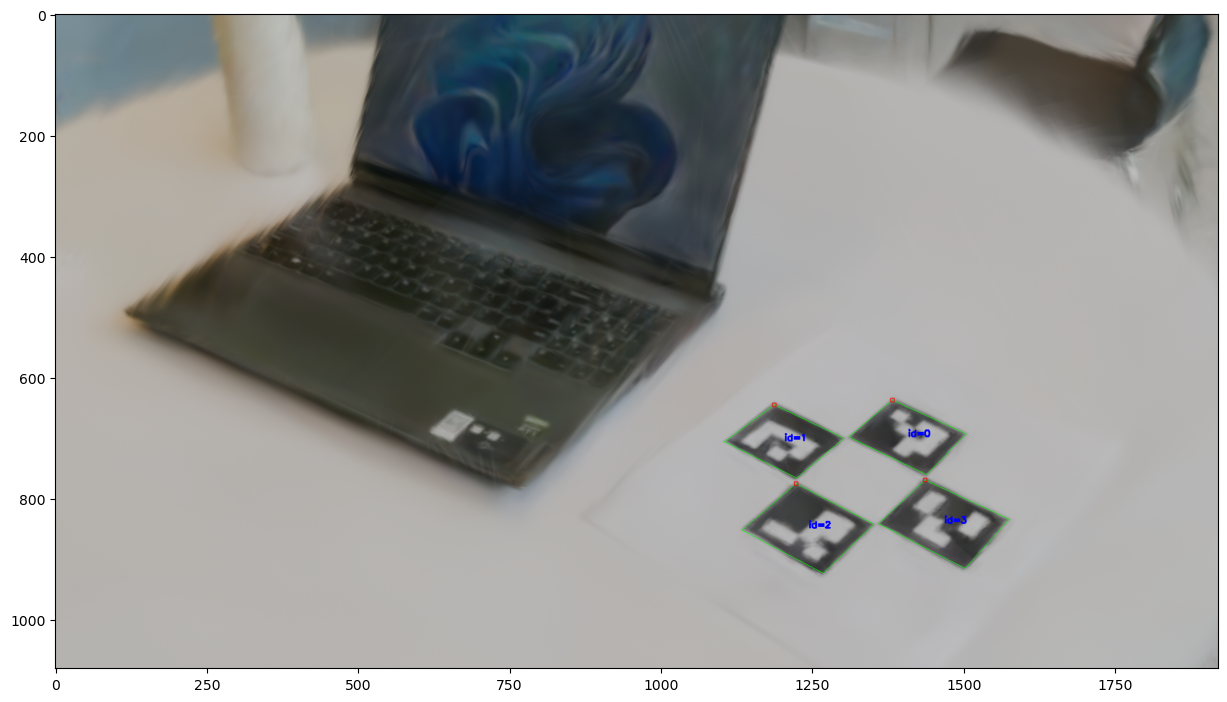

In [5]:
plt.figure(figsize=(15,15))
cv2.aruco.drawDetectedMarkers(frame, corners, ids)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [6]:
# sort the corners by id
id_argsort = np.argsort(ids.ravel())
id_sorted = ids.ravel()[id_argsort]
corners_sorted = [corners[i] for i in id_argsort]

print(id_sorted)
pprint(corners_sorted)

[0 1 2 3]
[array([[[1382.,  637.],
        [1504.,  693.],
        [1438.,  760.],
        [1310.,  698.]]], dtype=float32),
 array([[[1187.,  645.],
        [1302.,  700.],
        [1224.,  766.],
        [1104.,  706.]]], dtype=float32),
 array([[[1223.,  775.],
        [1351.,  842.],
        [1268.,  923.],
        [1134.,  852.]]], dtype=float32),
 array([[[1436.,  769.],
        [1575.,  834.],
        [1502.,  915.],
        [1359.,  841.]]], dtype=float32)]


In [7]:
params = cv2.aruco.EstimateParameters()
params.pattern = cv2.aruco.ARUCO_CCW_CENTER

rvecs, tvecs = cv2.aruco.estimatePoseSingleMarkers(
    corners_sorted, 6, K, None, None, None, None, params)[:2]

print("tvecs:")
pprint(tvecs.reshape(-1, 3))

print("rvecs: (deg)")
pprint(rvecs.reshape(-1, 3) / np.pi * 180)

tvecs:
array([[18.9347758 ,  7.79906671, 78.86881899],
       [10.29879588,  8.1516703 , 78.77184525],
       [10.90756061, 13.9577765 , 71.76462664],
       [19.32847299, 13.45513217, 71.09982409]])
rvecs: (deg)
array([[123.03349556,  45.95626716, -16.6356185 ],
       [122.11904317,  45.83750069, -19.13312029],
       [123.35089749,  45.65846683, -19.09359619],
       [121.68412701,  45.86956828, -18.57431821]])


In [8]:
# convert the rotation vector to rotation matrix
print(rvecs[0][0])

rvecs_mat = cv2.Rodrigues(np.mean(rvecs.reshape(-1, 3), axis=0))
print("rvecs_mat:")
pprint(rvecs_mat[0])

[ 2.14733959  0.80208817 -0.29034632]
rvecs_mat:
array([[ 0.76670474,  0.64062636,  0.04197281],
       [ 0.43447562, -0.46962788, -0.76855747],
       [-0.47264657,  0.60749282, -0.63840246]])


In [9]:
R_cv2blender = np.array([[1, 0, 0],
                         [0, -1, 0],
                         [0, 0, -1]])
R_rotx90 = np.array([[1, 0, 0],
                      [0, 0, -1],
                      [0, 1, 0]])
R_cv = np.array(rvecs_mat[0])
print("Mat_cv:")
pprint(R_cv)

Mat_blender = R_cv2blender @ R_cv @ R_rotx90
print("Mat_blender:")
pprint(Mat_blender)


Mat_cv:
array([[ 0.76670474,  0.64062636,  0.04197281],
       [ 0.43447562, -0.46962788, -0.76855747],
       [-0.47264657,  0.60749282, -0.63840246]])
Mat_blender:
array([[ 0.76670474,  0.04197281, -0.64062636],
       [-0.43447562,  0.76855747, -0.46962788],
       [ 0.47264657,  0.63840246,  0.60749282]])


In [10]:
offset = np.mean(tvecs.reshape(-1, 3), axis=0)
# offset[0] *= -1
pprint(offset)
pprint(R_cv2blender @ offset / offset[0] * 1)

array([14.86740132, 10.84091142, 75.12627874])
array([ 1.        , -0.72917326, -5.05308743])


In [11]:
def mean_center(ids, tvecs, rvecs, markerLength = 6):
    """
    Calculate the mean center of the markers
    for id = 0, local shift -y axis by markerLength
    for id = 1, local shift +x axis by markerLength
    for id = 2, local shift +y axis by markerLength
    for id = 3, local shift -x axis by markerLength
    Args:
        ids (_type_): [n] ids of the markers
        tvecs (_type_): [n x 3] translation vectors
        rvecs (_type_): [n x 3] rotation vectors
        markerLength (_type_): length of the marker
    """
    tvecs_shifted = tvecs.copy()
    for i in range(len(ids)):
        id = ids[i]
        R = cv2.Rodrigues(rvecs[i])[0]
        local_shift = np.zeros(3)
        if id == 0:
            local_shift = np.array([0, -markerLength, 0])
        elif id == 1:
            local_shift = np.array([markerLength, 0, 0])
        elif id == 2:
            local_shift = np.array([0, markerLength, 0])
        elif id == 3:
            local_shift = np.array([-markerLength, 0, 0])
        tvecs_shifted[i] += R @ local_shift
    print(tvecs_shifted)
    return np.mean(tvecs_shifted, axis=0)

In [12]:
mean_center = mean_center(ids, tvecs.reshape(-1, 3), rvecs.reshape(-1, 3))
print(mean_center)
mean_blender = R_cv2blender @ mean_center
print(mean_blender)
print(mean_blender * 0.04)


[[22.73225498  4.9648056  82.54932381]
 [ 5.71857678  5.57918414 81.6707947 ]
 [15.50924874 16.54182645 68.91030496]
 [15.46849617 16.20502597 67.42033188]]
[14.85714417 10.82271054 75.13768884]
[ 14.85714417 -10.82271054 -75.13768884]
[ 0.59428577 -0.43290842 -3.00550755]
